# INM707: Advanced Tasks

We ...

The work presented here is part of the coursework of the INM707 module at City, University of London. The Github repository can be found [here](https://github.com/yasirbarlas/City-INM707).

### Import Libraries

We use NumPy for most of the class and environment creation. Matplotlib is used for visualising the environment and for generating any plots.

In [68]:
# Import Relevant Libraries
from collections import deque
from IPython.display import clear_output

import os
import pickle
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import gymnasium as gym
from gymnasium.wrappers import FrameStack, TransformReward
from vizdoom import gymnasium_wrapper

### Set Random Seed and Default Device

In order to reproduce the results every time we run the notebook, we set a random seed. We also try to use a GPU if available.

In [69]:
# Set random seed for reproducibility
randomer = 50
random.seed(randomer)
np.random.seed(randomer)
torch.manual_seed(randomer)
torch.cuda.manual_seed_all(randomer)

# Default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


### Replay Buffer

In [70]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen = capacity)
    
    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

### Noisy Linear Network

In [71]:
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, std_init = 0.5):
        super(NoisyLinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.zeros((out_features, in_features), dtype = torch.float, device = device))
        self.weight_sigma = nn.Parameter(torch.zeros((out_features, in_features), dtype = torch.float, device = device))
        self.register_buffer("weight_epsilon", torch.zeros((out_features, in_features), dtype = torch.float, device = device))
        
        self.bias_mu = nn.Parameter(torch.zeros(out_features, dtype = torch.float, device = device))
        self.bias_sigma = nn.Parameter(torch.zeros(out_features, dtype = torch.float, device = device))
        self.register_buffer("bias_epsilon", torch.zeros(out_features, dtype = torch.float, device = device))
        
        self.reset_parameters()
        self.reset_noise()
    
    def forward(self, x):
        if self.training: 
            weight = self.weight_mu + self.weight_sigma.mul(self.weight_epsilon)
            bias = self.bias_mu + self.bias_sigma.mul(self.bias_epsilon)
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        
        return F.linear(x, weight, bias)
    
    def reset_parameters(self):
        mu_range = 1 / math.sqrt(self.weight_mu.size(1))
        
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.weight_sigma.size(1)))
        
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.bias_sigma.size(0)))
    
    def reset_noise(self):
        epsilon_in = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(self._scale_noise(self.out_features))
    
    def _scale_noise(self, size):
        x = torch.randn(size)
        x = x.sign().mul(x.abs().sqrt())
        return x

### Rainbow Deep Q-Network

In [72]:
class RainbowDQN(nn.Module):
    def __init__(self, input_shape, num_actions, num_atoms, Vmin, Vmax):
        super(RainbowDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.num_atoms = num_atoms
        self.Vmin = Vmin
        self.Vmax = Vmax
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size = 8, stride = 4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 4, stride = 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1),
            nn.ReLU()
        )
        
        self.noisy_value1 = NoisyLinear(self.feature_size(), 512)
        self.noisy_value2 = NoisyLinear(512, self.num_atoms)
        
        self.noisy_advantage1 = NoisyLinear(self.feature_size(), 512)
        self.noisy_advantage2 = NoisyLinear(512, self.num_atoms * self.num_actions)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        x = x / 255.0
        x = self.features(x)
        x = x.view(batch_size, -1)
        
        value = F.relu(self.noisy_value1(x))
        value = self.noisy_value2(value)
        
        advantage = F.relu(self.noisy_advantage1(x))
        advantage = self.noisy_advantage2(advantage)
        
        value = value.view(batch_size, 1, self.num_atoms)
        advantage = advantage.view(batch_size, self.num_actions, self.num_atoms)
        
        x = value + advantage - advantage.mean(1, keepdim = True)
        x = F.softmax(x.view(-1, self.num_atoms), dim = -1).view(-1, self.num_actions, self.num_atoms)
        
        return x
        
    def reset_noise(self):
        self.noisy_value1.reset_noise()
        self.noisy_value2.reset_noise()
        self.noisy_advantage1.reset_noise()
        self.noisy_advantage2.reset_noise()
        
    def feature_size(self):
        return self.features(torch.zeros(1, *self.input_shape)).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state = np.array(np.float32(state))
            state = torch.tensor(np.float32(state), dtype = torch.float, device = device).unsqueeze(0)
            dist = self.forward(state).data.cpu()
            dist = dist * torch.linspace(self.Vmin, self.Vmax, self.num_atoms, device = torch.device("cpu"))
            action = dist.sum(2).max(1)[1].numpy()[0]
        else:
            action = random.randrange(self.num_actions)
        return action

### Environment Selection

In [ ]:
env_id = "VizdoomDefendCenter-v0"
env = gym.make(env_id, frame_skip = 4)

print(f"Observation Space: {env.observation_space}\nAction Space: {env.action_space}")

env.action_space.seed(randomer)

### Environment Manipulation

In [74]:
class ObservationWrapper(gym.ObservationWrapper):
    """
    ViZDoom environments return dictionaries as observations, containing
    the main image as well other info.
    The image is also too large for normal training.

    This wrapper replaces the dictionary observation space with a simple
    Box space (i.e., only the RGB image), and also resizes the image to a
    smaller size.

    NOTE: Ideally, you should set the image size to smaller in the scenario files
          for faster running of ViZDoom. This can really impact performance,
          and this code is pretty slow because of this!
    """
    def __init__(self, env, shape = (84, 84)):
        super().__init__(env)
        self.image_shape = shape
        self.image_shape_reverse = shape[::-1]

        # Create new observation space with the new shape
        print(env.observation_space)
        num_channels = env.observation_space["screen"].shape[-1]
        new_shape = (shape[0], shape[1], num_channels)
        self.observation_space = gym.spaces.Box(
            0, 255, shape = new_shape, dtype = np.uint8
        )

    def observation(self, observation):
        observation = cv2.resize(observation["screen"], self.image_shape_reverse)
        return observation

class GrayScaleObservation(gym.ObservationWrapper):
    """Convert the image observation from RGB to gray scale.
    Example:
        >>> env = gym.make('CarRacing-v1')
        >>> env.observation_space
        Box(0, 255, (96, 96, 3), uint8)
        >>> env = GrayScaleObservation(gym.make('CarRacing-v1'))
        >>> env.observation_space
        Box(0, 255, (96, 96), uint8)
        >>> env = GrayScaleObservation(gym.make('CarRacing-v1'), keep_dim=True)
        >>> env.observation_space
        Box(0, 255, (96, 96, 1), uint8)
    """
    def __init__(self, env: gym.Env, keep_dim: bool = False):
        """Convert the image observation from RGB to gray scale.
        Args:
            env (Env): The environment to apply the wrapper
            keep_dim (bool): If `True`, a singleton dimension will be added, i.e. observations are of the shape AxBx1.
                Otherwise, they are of shape AxB.
        """
        super().__init__(env)
        self.keep_dim = keep_dim

        assert (
            isinstance(self.observation_space, gym.spaces.Box)
            and len(self.observation_space.shape) == 3
            and self.observation_space.shape[-1] == 3
        )

        obs_shape = self.observation_space.shape[:2]
        if self.keep_dim:
            self.observation_space = gym.spaces.Box(
                low = 0, high = 255, shape = (obs_shape[0], obs_shape[1], 1), dtype = np.uint8
            )
        else:
            self.observation_space = gym.spaces.Box(
                low = 0, high = 255, shape = obs_shape, dtype = np.uint8
            )

    def observation(self, observation):
        """Converts the colour observation to greyscale.
        Args:
            observation: Color observations
        Returns:
            Grayscale observations
        """

        observation = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
        if self.keep_dim:
            observation = np.expand_dims(observation, -1)
        return observation

# Apply Wrappers to environment
env = ObservationWrapper(env)
env = GrayScaleObservation(env)
#env = TransformReward(env, lambda r: r * 0.01)

if gym.__version__ < "0.26":
    env = FrameStack(env, num_stack = 4, new_step_api = True)
else:
    env = FrameStack(env, num_stack = 4)

print(f"Observation Space: {env.observation_space}\nAction Space: {env.action_space}")

Dict('gamevariables': Box(-3.4028235e+38, 3.4028235e+38, (2,), float32), 'screen': Box(0, 255, (240, 320, 3), uint8))
Observation Space: Box(0, 255, (4, 84, 84), uint8)
Action Space: Discrete(4)


### Model Hyperparameters

In [75]:
num_frames = 1500000
learning_rate = 0.00001
batch_size = 32
gamma = 0.99

num_atoms = 51
Vmin = -10
Vmax = 10

max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.000005

### $\epsilon$-Greedy Selection

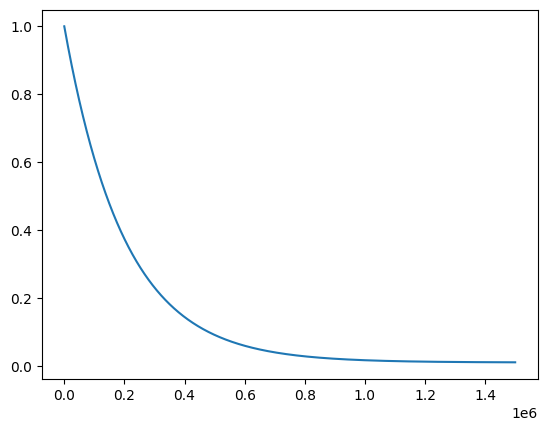

In [76]:
epsilon_by_frame = lambda frame: min_epsilon + (max_epsilon - min_epsilon) * np.exp(- decay_rate * frame)

plt.plot([epsilon_by_frame(i) for i in range(num_frames)])
plt.show()

### Initialise DQN Model

In [77]:
current_model = RainbowDQN(env.observation_space.shape, env.action_space.n, num_atoms, Vmin, Vmax)
target_model = RainbowDQN(env.observation_space.shape, env.action_space.n, num_atoms, Vmin, Vmax)
current_model.to(device)
target_model.to(device)

optimizer = optim.Adam(current_model.parameters(), lr = learning_rate)

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

In [78]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

update_target(current_model, target_model)

### Loss Function

In [79]:
def projection_distribution(next_state, rewards, dones):
    device = next_state.device
    
    batch_size = next_state.size(0)
    
    delta_z = float(Vmax - Vmin) / (num_atoms - 1)
    support = torch.linspace(Vmin, Vmax, num_atoms, device = device)
    
    next_dist = target_model(next_state).to(device) * support
    next_action = next_dist.sum(2).max(1)[1]
    next_action = next_action.unsqueeze(1).unsqueeze(1).expand(next_dist.size(0), 1, next_dist.size(2))
    next_dist = next_dist.gather(1, next_action).squeeze(1)
        
    rewards = rewards.unsqueeze(1).expand_as(next_dist).to(device)
    dones = dones.unsqueeze(1).expand_as(next_dist).to(device)
    support = support.unsqueeze(0).expand_as(next_dist)
    
    Tz = rewards + (1 - dones) * 0.99 * support
    Tz = Tz.clamp(min = Vmin, max = Vmax)
    b = (Tz - Vmin) / delta_z
    l = b.floor().long()
    u = b.ceil().long()
        
    offset = torch.linspace(0, (batch_size - 1) * num_atoms, batch_size, device = device).long().unsqueeze(1).expand(batch_size, num_atoms)

    proj_dist = torch.zeros(next_dist.size(), device = device)    
    proj_dist.view(-1).index_add_(0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1))
    proj_dist.view(-1).index_add_(0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1))
        
    return proj_dist

In [80]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size) 

    state = torch.tensor(np.float32(state), dtype = torch.float, device = device)
    next_state = torch.tensor(np.float32(next_state), dtype = torch.float, device = device)
    action = torch.tensor(action, dtype = torch.long, device = device)
    reward = torch.tensor(reward, dtype = torch.float, device = device)
    done = torch.tensor(done, dtype = torch.float, device = device)

    proj_dist = projection_distribution(next_state, reward, done)
    
    dist = current_model(state)
    action = action.unsqueeze(1).unsqueeze(1).expand(batch_size, 1, num_atoms)
    dist = dist.gather(1, action).squeeze(1)
    dist.data.clamp_(0.01, 0.99)
    loss = -(proj_dist * dist.log()).sum(1)
    loss = loss.mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    current_model.reset_noise()
    target_model.reset_noise()
    
    del dist, proj_dist, state, action, reward, next_state, done
    
    return loss

### Plotting Function

In [81]:
# Define a function to calculate moving average
def moving_average(data, window_size = 100):
    return np.convolve(a = data, v = np.ones(window_size), mode = "valid") / window_size

def plot(rewards, losses):
    clear_output(True)
    plt.figure(figsize = (40, 6))
    
    plt.subplot(131)
    plt.title("DQN Rewards Per Episode")
    plt.plot(rewards, label = "Reward")
    if len(rewards) >= 100:
        plt.plot(moving_average(rewards), label = "Moving Average", color = "red")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    
    plt.subplot(132)
    plt.title("DQN Loss Per Frame")
    plt.plot(losses, label = "DQN Loss")
    plt.xlabel("Frame")
    plt.ylabel("Loss")
    
    plt.savefig("rainbow_dqn_plot.pdf")
    plt.show()

### Shrink Learning Rate During Training

In [82]:
def adjust_learning_rate(optimizer, shrink_factor):
    """
    Shrinks learning rate by a specified factor

    optimizer: optimizer whose learning rate must be shrunk
    shrink_factor: factor in interval (0, 1) to multiply learning rate with
    """

    print("\nDECAYING learning rate")
    for param_group in optimizer.param_groups:
        param_group["lr"] = param_group["lr"] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]["lr"]))

### Training

In [83]:
losses = []
all_rewards = []
epsilons = []

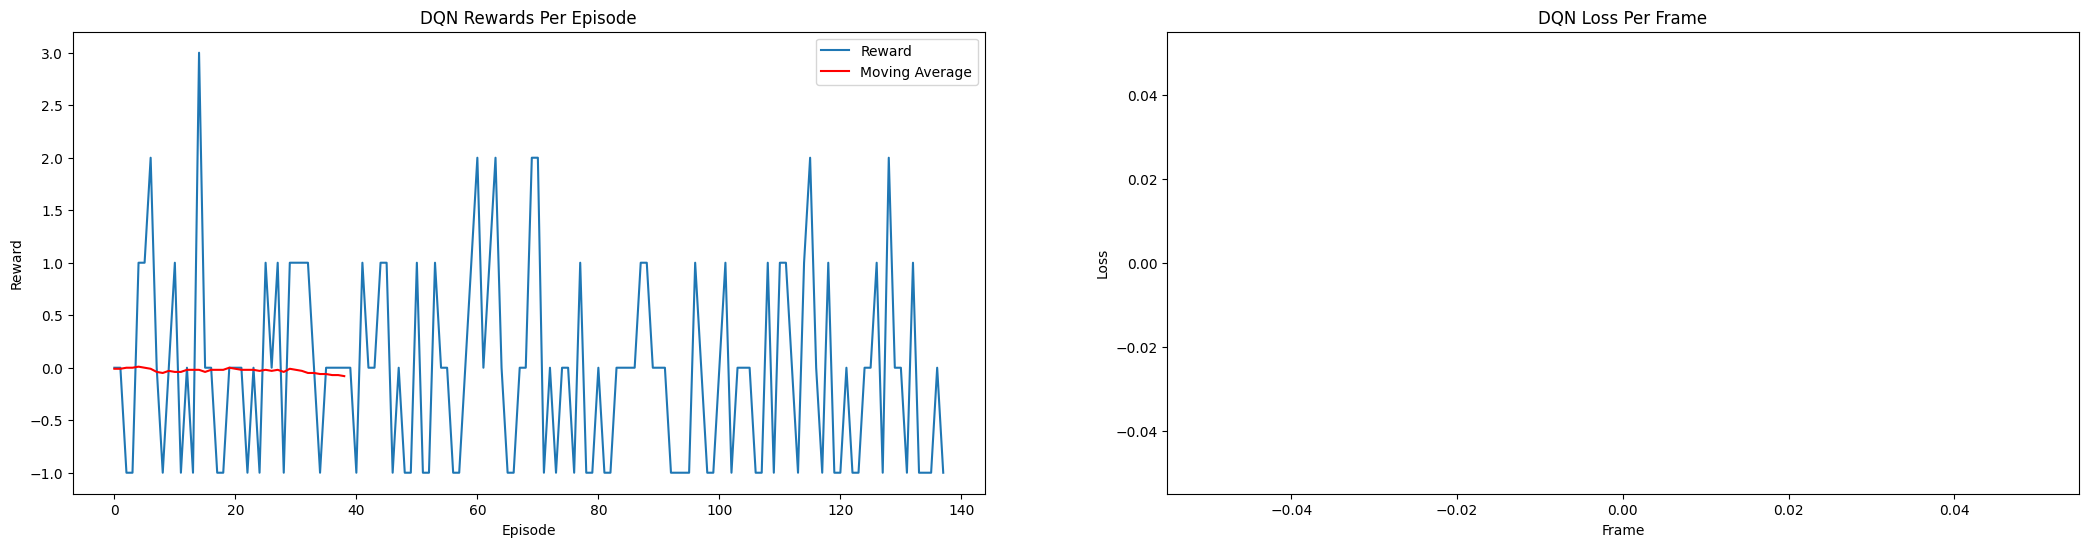

In [84]:
%%time

episode_reward = 0

state, _ = env.reset(seed = randomer)
for frame_idx in range(1, num_frames + 1):
    # At the halfway point, reduce learning rate by a tenth
    if frame_idx == int(num_frames // 2):
        adjust_learning_rate(optimizer, 0.1)

    epsilon = epsilon_by_frame(frame_idx)
    epsilons.append(epsilon)
    
    action = current_model.act(state, epsilon)

    next_state, reward, done, _, _ = env.step(action)

    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state, _ = env.reset(seed = randomer)
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 1000 == 0:
        plot(all_rewards, losses)
        update_target(current_model, target_model)

        # Create checkpoint folder
        if not os.path.exists("checkpoints"):
            os.makedirs("checkpoints")
    
        # Save the model checkpoint
        checkpoint_name = f"checkpoint_rainbow_dqn_latest.pth.tar"
        checkpoint_path = os.path.join("checkpoints", checkpoint_name)
        torch.save({"current_model": current_model.state_dict(), "target_model": target_model.state_dict(), "optimizer": optimizer.state_dict(), "losses": losses, "rewards": all_rewards, "frame": frame_idx}, checkpoint_path)

In [ ]:
%%time
# Save lists to a file
with open("rainbow-dqn-results.pkl", "wb") as f:
    pickle.dump(losses, f)
    pickle.dump(all_rewards, f)
    pickle.dump(epsilons, f)

CPU times: total: 0 ns
Wall time: 0 ns
